# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


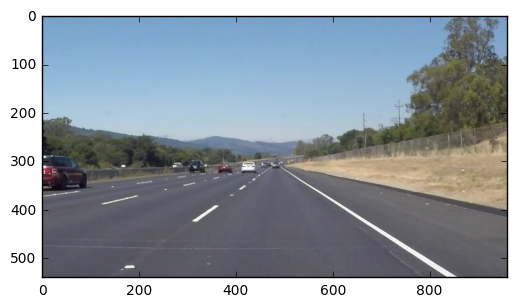

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [4]:
import math
import copy

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def perpendicular_distance(line, point):
    """
    Computes the perpendicular distance between the line and the point 
    provided as parameters.
    - line is in fhe format [x1, y1, x2, y2]
    - point is in the format [x, y]
    """
    line_slope = (line[1] - line[3])/(line[0] - line[2])
    b = 1
    a = - line_slope
    c = line_slope*line[0] - line[1]
    return np.abs(a*point[0] + b*point[1] + c)/np.sqrt(a**2 + b**2)

def vanishing_point_distance_selection(lines, vanishing_point, max_distance):
    """
    Filtering of the list of lines provided as parameter as a function of the perpendicular distance
    between those lines and the vanishing point. The filtering criterion is given by max_distance in
    pixels.
    """
    out_lines = []
    
    for line in lines:
        d = perpendicular_distance(line[0], vanishing_point)
        if d < max_distance:
            out_lines.append(line)
            
    return out_lines

def plot_cross(img, center, length, thickness, color):
    """ 
    Plot a cross centered on 'center', with a total length of 'length', a thickness of 'thickness' and
    a color of 'color'. The cross is plotted on 'img'.
    """
    pUp = (center[0], center[1]+int(length/2))
    pLe = (center[0]-int(length/2), center[1])
    pRi = (center[0]+int(length/2), center[1])
    pDo = (center[0], center[1]-int(length/2))
    cv2.line(img, pUp, pDo, color, thickness)
    cv2.line(img, pLe, pRi, color, thickness)

def line_length(x1, y1, x2, y2):
    """
    Computation of the length of the segment defined by the points [x1, y1] and [x2, y2].
    """
    return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_vanishing_point(img, lines, h):
    """
    Estimation of the position of the vanishing point. All lines proived as parameter are extrapolated
    to the borders of the image of height h. They are plotted in black and white a color intensity proportional
    to the length of the segment. The longer the segment, the brighter the extrapolated line. All plotted lines
    are summed linearly, which results in brighter spots where many line intersects. The maximum is taken as the
    position of the vanishing point.
    """
    
    total_length = 0
    extrapolated_lines = []
    
    # Line extrapolation
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # Line parameters
            s = (y2-y1)/(x2-x1)
            b = - s*x1 + y1;
            
            # Extrapolate 
            p1 = (- int(b/s), 0)
            p2 = (int((h-b)/s), h)
            
            # Length
            l = line_length(p1[0], p1[1], p2[0], p2[1])
            total_length += l
            
            # Save data
            extrapolated_lines.append([p1, p2, l])
     
    # Line plotting
    for line in extrapolated_lines:
        line_image = np.copy(img)*0
        c = int(255*line[2]/total_length)
        cv2.line(line_image, line[0], line[1], [c, c, c], 5)
        img = cv2.addWeighted(line_image, 1, img, 1, 0)
    
    # Vanishing point position extraction
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(img)
    
    return max_loc

def cluster_lines(lines, delta_slope):
    """
    Clustering of lines by their slope value. The clustering proceeds until all remaining lines have a difference
    in slope greater than 'delta_slope'.
    """
    converged = False
    clustered_lines = copy.copy(lines)
    
    # Clustering loop
    while not converged and len(clustered_lines) > 1:
        
        slope_list = np.array([(y2-y1)/(x2-x1) for line in clustered_lines for x1,y1,x2,y2 in line])
        s1, s2 = find_two_closest(slope_list)
        
        # Convergence
        if np.abs(slope_list[s1] - slope_list[s2]) >= delta_slope:
            converged = True
            
        # List reduction and next iteration
        else:
            l = (clustered_lines[s1][0]+clustered_lines[s2][0])/2
            del clustered_lines[max(s1,s2)]
            del clustered_lines[min(s1,s2)]
            clustered_lines.append([l.astype(int)])
            
    return clustered_lines

def find_two_closest(numbers):
    """
    Computes the closest values in the list numbers. 
    Returns the index of those values in numbers.
    """
    dist = np.abs(numbers[None,:] - numbers[:, None])
    np.fill_diagonal(dist, np.inf)
    x1, x2 = np.unravel_index(np.argmin(dist), dist.shape)
    return x1, x2

def extrapolate(line, y_min, y_max):
    """
    Extrapolates the line in the format [x1, y1, x2, y2] up to the y values of y_min and y_max.
    """
    for x1,y1,x2,y2 in line:
        
        # Line parameters
        s = (y2-y1)/(x2-x1)
        b = - s*x1 + y1;

        # Extrapolate 
        l = np.array([int((y_min-b)/s), y_min, int((y_max-b)/s), y_max])
            
    return [[l.astype(int)]]

def closest_to_camera(lines):
    """
    Returns the line that is the closest to the camera in the list 'lines'. 
    The criterion "closet to the camera" is defined by the line with the highest slope in the list.
    """
    s0 = 0
    index = 0
    
    # Lines is not empty and the highest slope is returned
    if len(lines) > 0:
        for i, line in enumerate(lines): 
            for x1,y1,x2,y2 in line:
                s = np.abs((y2-y1)/(x2-x1))
                if s > s0:
                    s = s0
                    index = i
        return lines[index]
    
    # Lines is empty and an empty list is returned
    else:
        return lines

run your solution on all test_images and make copies into the test_images directory).

In [5]:
def lane_detect(base_image):
    """
    Detection of the vanishing point, left and right lane in the base_image.
    The detection is realised on a grayscale version of the image.
    A smoothing, canny edge detector and hough transform pass is applied on a masked version of this image.
    Subsequently, unlikely lines are filtered based on their slope value and classified in left and right lane.
    Resulting lines are used to estimated the position of the vanishing point.
    Lines too far away from the vanishing point are then filtered from the left and right set.
    Similar lines are clustered based on their slope value.
    Finally, the lines closest to the camera are selected as outputs.
    """
    
    # Image parameters
    x_size = base_image.shape[1]
    y_size = base_image.shape[0]
    
    # Tranform to grayscale
    gray_image = grayscale(base_image)
    
    # Smooth image
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)
    
    # Canny edge
    low_threshold = 55
    high_threshold = 140
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Image masking
    height_ratio = 0.59
    width_ratio = 0.07
    mask = np.zeros_like(gray_image)   
    ignore_mask_color = 200   
    vertices = np.array([[(0, y_size), (x_size*(1-width_ratio)/2, y_size*height_ratio), 
                          (x_size*(1+width_ratio)/2, y_size*height_ratio), (x_size, y_size)]], dtype=np.int32)
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(edges, mask)
    
    # Hough transform
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 40
    max_line_gap = 10
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold,
                            np.array([]), min_line_length, max_line_gap)
    
    # Slope filtering and association
    left_lines = []
    right_lines = []
    
    right_interval = [-45, -25]
    left_interval = [25, 45]
    
    left_interval = [np.tan(x*np.pi/180) for x in left_interval]
    right_interval = [np.tan(x*np.pi/180) for x in right_interval]

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y1-y2)/(x2-x1);
            
            if left_interval[0]<= slope <=left_interval[1]:      
                left_lines.append(line)

            elif right_interval[0]<= slope <=right_interval[1]:
                right_lines.append(line)


    # Vanishing point computation
    vanishing_image = np.copy(gray_image)*0
    max_loc = get_vanishing_point(vanishing_image, left_lines + right_lines, y_size)
    
    # Distance selection
    max_distance = 5;
    filtered_left_lines = vanishing_point_distance_selection(left_lines, max_loc, max_distance)
    filtered_right_lines = vanishing_point_distance_selection(right_lines, max_loc, max_distance)
    
    # Clustering
    clustered_left_lines = cluster_lines(filtered_left_lines, 0.2)
    clustered_right_lines = cluster_lines(filtered_right_lines, 0.2)
    
    # Filter out lines clostest to the camera
    out_left_lines = closest_to_camera(clustered_left_lines)
    out_right_lines = closest_to_camera(clustered_right_lines)
      
    return out_left_lines, out_right_lines, max_loc

def plot_lines(base_image, left_line, right_line):
    """
    Plot of the left and right lane on the base image.
    """
    # Line extrapolation and plotting
    y_size = base_image.shape[0]
    y_min = y_size
    y_max = y_size/1.5
    line_image = np.copy(base_image)*0
    
    draw_lines(line_image, extrapolate(left_line,y_min, y_max),color = [0, 0, 255], thickness = 20)
    draw_lines(line_image, extrapolate(right_line,y_min, y_max),color = [0, 255, 0], thickness = 20)
    
    combo = cv2.addWeighted(line_image, 0.8, base_image, 1, 0)
    
    return combo


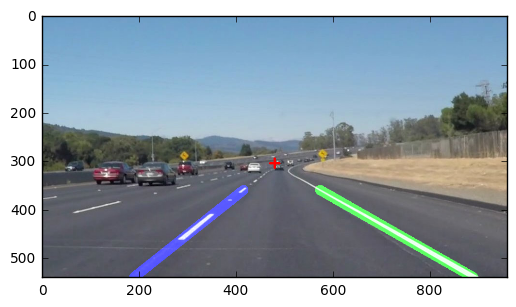

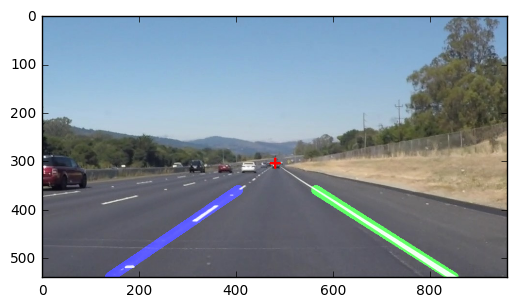

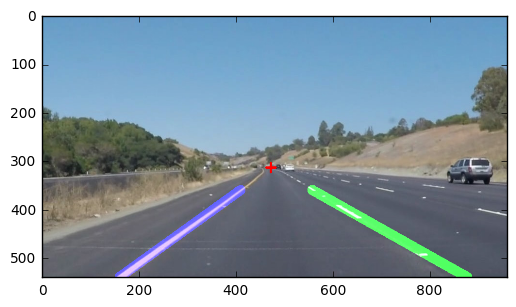

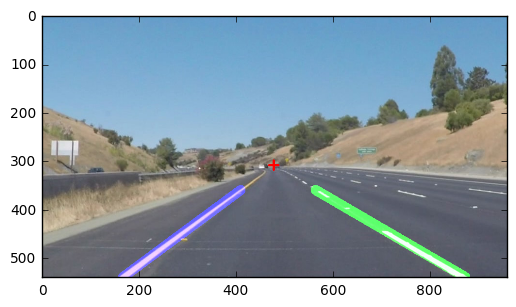

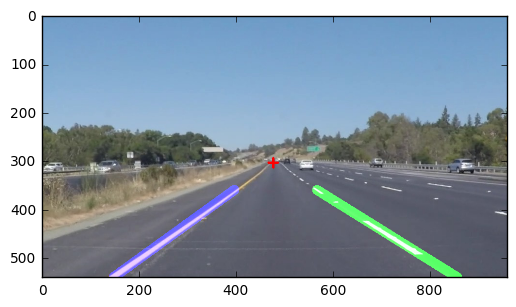

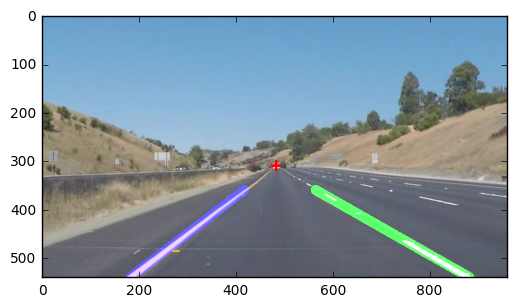

In [6]:
image_list = os.listdir("test_images/")
    
for image_path in image_list:
    image = mpimg.imread("test_images/" + image_path)
    left_lines, right_lines, vanishing_point = lane_detect(image)
    
    plot_cross(image, vanishing_point, 20, 3, [255, 0, 0])
    combo = plot_lines(image, left_lines, right_lines)
    plt.figure()
    plt.imshow(combo)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):    
    """
    Processes frames from a video.
    This function uses the previously defined lane_detect and adds an extra layer of time averaging.
    This is realised through the global variables for the left and right lane and the vanishing point.
    """
    global line_left, line_right, vanishing_point
    
    # Computation of new values based on the current image
    new_line_left, new_line_right, new_vanishing_point = lane_detect(image)
    
    # If the global variables do not exist, they are initialised to the current output
    if 'line_left' not in globals():
        line_left = new_line_left
    if 'line_right' not in globals():
        line_right = new_line_right
    if 'vanishing_point' not  in globals():
        vanishing_point = np.array(new_vanishing_point)
    
    # If the variables exist, they are averaged with their previous value
    else: 
        
        # Value is not updated if the algorithm failed to detect a lane on the current image
        if np.array(new_line_left).shape[0] > 0:
            line_left = 0.8*np.array(line_left) + 0.2*np.array(new_line_left)
        if np.array(new_line_right).shape[0] > 0:
            line_right = 0.8*np.array(line_right) + 0.2*np.array(new_line_right)
        
        vanishing_point = 0.9*np.array(vanishing_point) + 0.1*np.array(new_vanishing_point)
    
    # Plot lines
    plot_cross(image, vanishing_point.astype(int), 20, 3, [255, 0, 0])
    combo = plot_lines(image, line_left, line_right)
    
    return combo


Let's try the one with the solid white lane on the right first ...

In [10]:
# If global variables already exist, they are deleted
if 'line_left' in globals():
    del line_left, line_right, vanishing_point
    
# Treatement of the video
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 39.64it/s]  1%|█                                                                                 | 3/222 [00:00<00:08, 24.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 6.2 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
if 'line_left' in globals():
    del line_left, line_right, vanishing_point
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:19<00:00, 34.36it/s]  0%|▎                                                                                 | 3/682 [00:00<00:26, 25.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 20.6 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

I was able to obtain very good results by basing my approach on this paper:
http://ceng.anadolu.edu.tr/cv/LaneDetection/LaneDetection.htm

Using more advanced and robust line detection methods will probably allow me to reduce the averaging, hereby decreasing the lag in the line tracking. One way to explore woud be the usage of other color spaces such as HSV that are less sensitive to shadows and light intensity variation.

An interesting case to observe would be the presence of road markins such as pedestrian crossings or stop markins. This would certainly affect the detection algorithm badly. Another case to study is the effect of rain, mist, snow, etc.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
if 'line_left' in globals():
    del line_left, line_right, vanishing_point
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 17.82it/s]  1%|▋                                                                                 | 2/251 [00:00<00:18, 13.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 14.9 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))